# Regression Model Comparison using `PyCaret`

In [29]:
# !pip install pycaret # if necessary

In [30]:
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf

from pycaret.regression import *

import seaborn as sns

### 1. Download IONQ data using `yfinance`

In [31]:
stockCode = "C"
# startDate = "2022-07-01"
# endDate = "2023-06-30"

In [32]:
ticker = yf.Ticker(stockCode)
price_hist = ticker.history(period="max", interval="1d")

price_hist.index = [x.date() for x in price_hist.index]
price_hist.shape

(11753, 7)

### 2. Add features
- Shift: Price before n days
- MA: Avg. price for last n days
- VolAvg: Avg. vol for last n days

In [33]:
close = price_hist[["Close", "Volume"]].copy()

close["Shift_1"] = close["Close"].shift(1)
close["Shift_5"] = close["Close"].shift(5)
close["Shift_20"] = close["Close"].shift(20)
close["Shift_60"] = close["Close"].shift(60)
close["Shift_120"] = close["Close"].shift(120)
close["Shift_240"] = close["Close"].shift(240)

close["MA_5"] = close["Close"].rolling(5).mean()
close["MA_20"] = close["Close"].rolling(20).mean()
close["MA_60"] = close["Close"].rolling(60).mean()
close["MA_120"] = close["Close"].rolling(120).mean()
close["MA_240"] = close["Close"].rolling(240).mean()

close["Vol_1"] = close["Volume"].shift(1)
close["VolAvg_5"] = close["Volume"].rolling(5).mean()
close["VolAvg_20"] = close["Volume"].rolling(20).mean()
close["VolAvg_60"] = close["Volume"].rolling(60).mean()
close["VolAvg_120"] = close["Volume"].rolling(120).mean()
close["VolAvg_240"] = close["Volume"].rolling(240).mean()

In [34]:
close = close.dropna()
print(close.shape)

(11513, 19)


In [35]:
close.head(5)

,Close,Volume,Shift_1,Shift_5,Shift_20,Shift_60,Shift_120,Shift_240,MA_5,MA_20,MA_60,MA_120,MA_240,Vol_1,VolAvg_5,VolAvg_20,VolAvg_60,VolAvg_120,VolAvg_240
1977-12-14,7.152093,20964,7.105947,7.059807,7.036738,7.382803,7.382803,7.221305,7.087493,7.105949,7.042503,7.235917,7.270620,10120.0,25638.4,26795.20,29879.550000,28022.091667,30239.966667
1977-12-15,7.152093,25060,7.152093,7.036738,7.105947,7.336659,7.382803,7.244378,7.110564,7.108257,7.039427,7.233995,7.270235,20964.0,20192.6,27084.35,28546.216667,27837.350000,30201.812500
1977-12-16,7.152093,37590,7.152093,7.059807,7.082878,7.267449,7.336659,7.198232,7.129021,7.111718,7.037504,7.232457,7.270043,25060.0,22746.8,28204.80,28196.816667,27963.850000,30294.179167
1977-12-19,7.105947,49398,7.152093,7.082878,7.105947,7.244378,7.336659,7.152093,7.133635,7.111718,7.035197,7.230534,7.269851,37590.0,28626.4,29927.70,28859.466667,28210.841667,30337.354167
1977-12-20,7.082878,23133,7.105947,7.105947,7.175162,7.175162,7.382803,7.175162,7.129021,7.107103,7.033659,7.228035,7.269466,49398.0,31229.0,30313.25,28771.116667,28267.066667,30348.400000


In [36]:
close.tail(5)

,Close,Volume,Shift_1,Shift_5,Shift_20,Shift_60,Shift_120,Shift_240,MA_5,MA_20,MA_60,MA_120,MA_240,Vol_1,VolAvg_5,VolAvg_20,VolAvg_60,VolAvg_120,VolAvg_240
2023-08-07,45.830002,16972000,45.709999,47.113369,45.146191,45.838165,49.868355,49.055691,45.905798,46.460054,46.071658,46.434726,45.919193,18320300.0,15415920.0,18764530.0,1.588505e+07,1.754237e+07,1.780871e+07
2023-08-08,45.160000,18524500,45.830002,46.530136,45.996330,45.502064,50.464817,48.768532,45.631771,46.418238,46.065957,46.390519,45.904158,16972000.0,16077000.0,18984135.0,1.600674e+07,1.756104e+07,1.783954e+07
2023-08-09,44.439999,13957100,45.160000,45.778854,46.836582,44.928719,50.670158,48.825962,45.364000,46.298409,46.057812,46.338601,45.885883,18524500.0,16248200.0,18783965.0,1.602586e+07,1.760055e+07,1.785119e+07
2023-08-10,44.340000,12112300,44.439999,45.680000,47.133141,45.521835,50.318146,49.831005,45.096000,46.158752,46.038114,46.288783,45.863004,13957100.0,15977240.0,18079045.0,1.602920e+07,1.762317e+07,1.784929e+07
2023-08-11,44.570000,11971200,44.340000,45.709999,45.225277,44.760666,50.279034,47.648628,44.868000,46.125988,46.034937,46.241208,45.850176,12112300.0,14707420.0,16747520.0,1.607537e+07,1.762045e+07,1.781563e+07


### 3. Visualization

In [37]:
close = close.drop(columns=["Volume"])
print(close.shape)

(11513, 18)


In [38]:
#sns.pairplot(close)

### 4. Model Comparison

In [39]:
init_model = setup(
    session_id=123,
    data=close,
    target="Close",
    normalize=True,
    normalize_method="zscore",
    train_size=0.75,
    fold_strategy="kfold",
    fold=10
)

,Description,Value
0,Session id,123
1,Target,Close
2,Target type,Regression
3,Original data shape,"(11513, 18)"
4,Transformed data shape,"(11513, 18)"
5,Transformed train set shape,"(8634, 18)"
6,Transformed test set shape,"(2879, 18)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


In [40]:
compared = compare_models(n_select=10, sort="MSE")

print(compared)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,1.1828,6.4342,2.5275,0.9994,0.0237,0.0149,0.6540
lr,Linear Regression,1.1828,6.4347,2.5276,0.9994,0.0237,0.0149,1.3840
ridge,Ridge Regression,1.1957,6.5370,2.5466,0.9994,0.0239,0.0151,0.6310
lar,Least Angle Regression,1.2036,6.5789,2.5552,0.9994,0.0246,0.0153,0.6280
omp,Orthogonal Matching Pursuit,1.2878,7.5105,2.7287,0.9993,0.0252,0.0159,0.6330
lightgbm,Light Gradient Boosting Machine,1.3227,7.7381,2.7712,0.9993,0.0270,0.0174,0.9560
et,Extra Trees Regressor,1.3046,7.8256,2.7857,0.9993,0.0255,0.0160,1.0870
huber,Huber Regressor,1.3565,7.9617,2.8098,0.9993,0.0277,0.0175,0.7200
llar,Lasso Least Angle Regression,1.5701,8.0030,2.8195,0.9993,0.0505,0.0405,0.6530
gbr,Gradient Boosting Regressor,1.4145,8.0100,2.8188,0.9993,0.0298,0.0209,1.5160


Processing:   0%|          | 0/86 [00:00<?, ?it/s]

[BayesianRidge(), LinearRegression(n_jobs=-1), Ridge(random_state=123), Lars(random_state=123), OrthogonalMatchingPursuit(), LGBMRegressor(n_jobs=-1, random_state=123), ExtraTreesRegressor(n_jobs=-1, random_state=123), HuberRegressor(), LassoLars(random_state=123), GradientBoostingRegressor(random_state=123)]


### 5. Create Model

In [41]:
br_model = create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.1601,5.6166,2.3699,0.9995,0.0241,0.0151
1,1.1883,7.2406,2.6908,0.9993,0.0258,0.0149
2,1.3336,7.6134,2.7592,0.9994,0.0223,0.0148
3,1.2473,8.5360,2.9216,0.9993,0.0280,0.0156
4,1.0251,4.6690,2.1608,0.9996,0.0271,0.0151
5,1.2079,6.4431,2.5383,0.9995,0.0212,0.0146
6,1.1381,5.2205,2.2848,0.9995,0.0206,0.0140
7,1.2157,6.4604,2.5417,0.9995,0.0211,0.0143
8,1.0840,6.0605,2.4618,0.9994,0.0240,0.0150


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

## 5-1 Run by time - Predicting the latest price by decrementing time t in training 

In [42]:
# do by original aggregated table
#ticker_data = close[list(close.columns[1:])+["Close"]]

# do by almost actuals
ticker_data = close[["Shift_1", "Vol_1","Close"]]
ticker_data.head()

,Shift_1,Vol_1,Close
1977-12-14,7.105947,10120.0,7.152093
1977-12-15,7.152093,20964.0,7.152093
1977-12-16,7.152093,25060.0,7.152093
1977-12-19,7.152093,37590.0,7.105947
1977-12-20,7.105947,49398.0,7.082878


In [78]:
%%time

from sklearn import linear_model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

X = ticker_data[list(ticker_data.columns)[:-1]]
y = ticker_data[["Close"]]

# arbitrary stop point ~ 150 days before the destination time t
stop = 150

n_ydays = 2

result_dic = {"y_trues":[], 
              "y_preds":[]}

for lindex in range(-1,-(n_ydays+1), -1):

    y_true, y_pred = [], []
    last_index = ticker_data.index[lindex]
    
    count = 0
    
    for index in ticker_data.index[lindex-stop:lindex]:
        
        if count == stop:
            break
        
        X_train = X.loc[index:last_index,:]
        X_test  = X.loc[[last_index],:]
        y_train = y.loc[index:last_index,["Close"]]
        y_test  = y.loc[last_index,"Close"]
        
        #print(X_train)
        #break
        # model
        model = linear_model.BayesianRidge()
        
        #print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        #break
        model.fit(X_train, y_train) 
        # prediction
        yhat = model.predict(X_test)

        # store
        count +=1 
        y_true.append(y_test)
        y_pred.append(yhat[0])
        
    result_dic["y_trues"].append(y_true)
    result_dic["y_preds"].append(y_pred)

CPU times: total: 6.98 s
Wall time: 1.39 s


In [79]:
len(result_dic["y_trues"]) # from the last available time t of y to 10 previous days 

2

In [80]:
y_trues = result_dic["y_trues"]
y_preds = result_dic["y_preds"]

In [81]:
cum_scores = {
    "mae":[0]*stop,
    "mse":[0]*stop,
    "rmse":[0]*stop,
    "mape":[0]*stop,
}

for i in range(len(y_trues)):
    yt = y_trues[i]
    yp = y_preds[i]
    
    size = len(yt)
    
    index = 0
    
    for k in range(size-1,-1,-1):
        t = yt[k:]
        p = yp[k:]
    
        mae = mean_absolute_error(t, p)
        mse= mean_squared_error(t, p)
        rmse = mean_squared_error(t, p, squared=False)
        mape = mean_absolute_percentage_error(t, p)
        
        cum_scores["mae"][index] += mae
        cum_scores["mse"][index] += mse
        cum_scores["rmse"][index] += rmse
        cum_scores["mape"][index] += mape
        
        index += 1
        
df = pd.DataFrame(cum_scores)

df = df / len(y_trues)
df.head()

,mae,mse,rmse,mape
0,3.552714e-14,2.069971e-27,3.552714e-14,7.975222e-16
1,4.150132e-06,5.555261e-11,5.869173e-06,9.316738e-08
2,2.303322e-02,1.944748e-03,3.988992e-02,5.187595e-04
3,6.383073e-02,1.053757e-02,9.967606e-02,1.436922e-03
4,6.501723e-02,9.675994e-03,9.485139e-02,1.463830e-03


mae


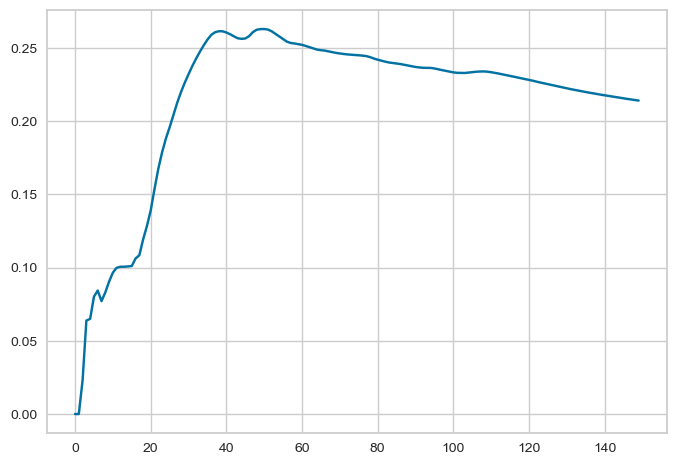

mse


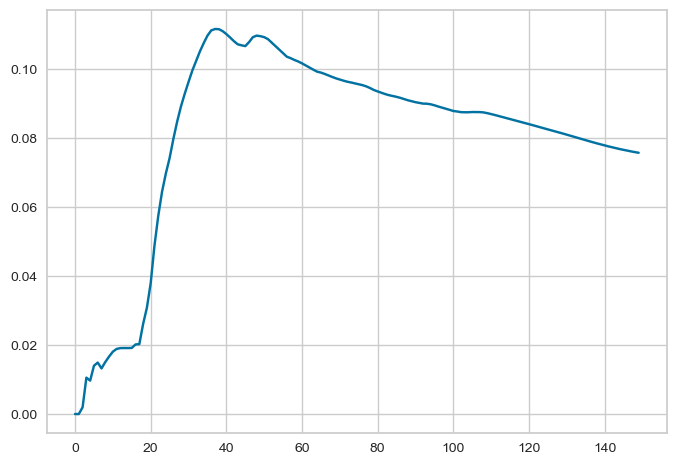

rmse


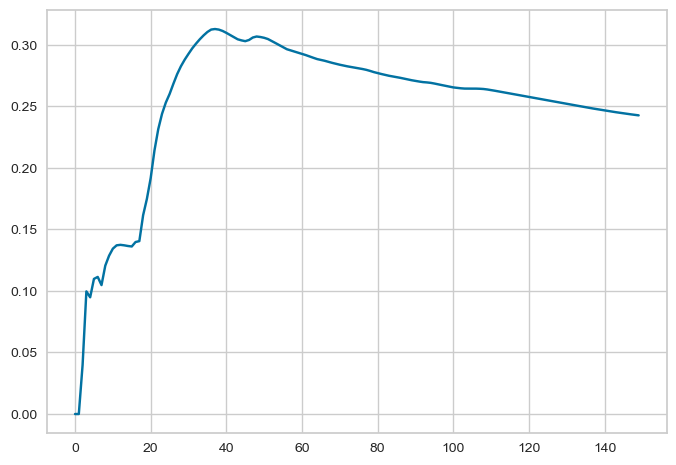

mape


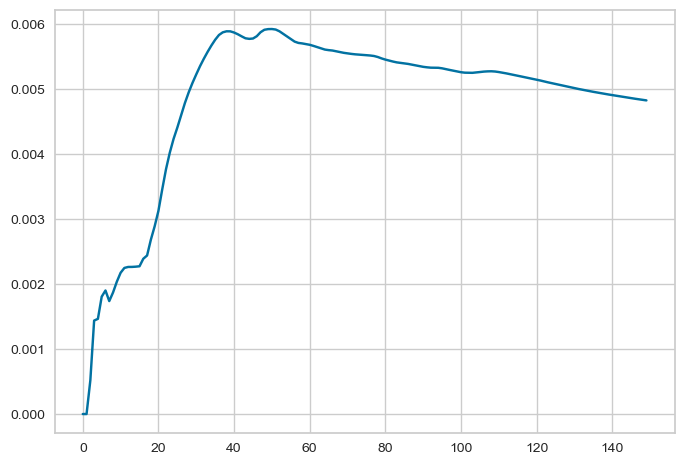

In [82]:
import matplotlib.pyplot as plt

for col in df.columns:
    print(col)
    df[col].plot()
    plt.show()

mae


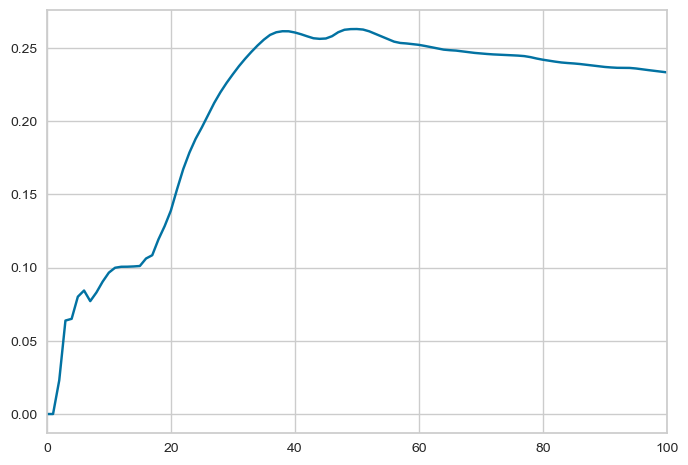

mse


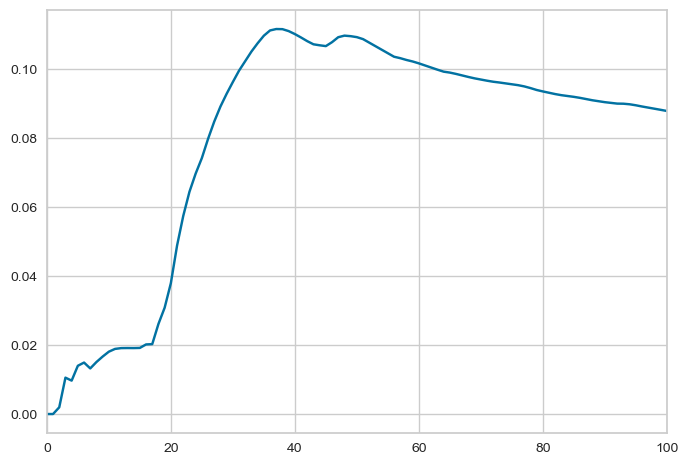

rmse


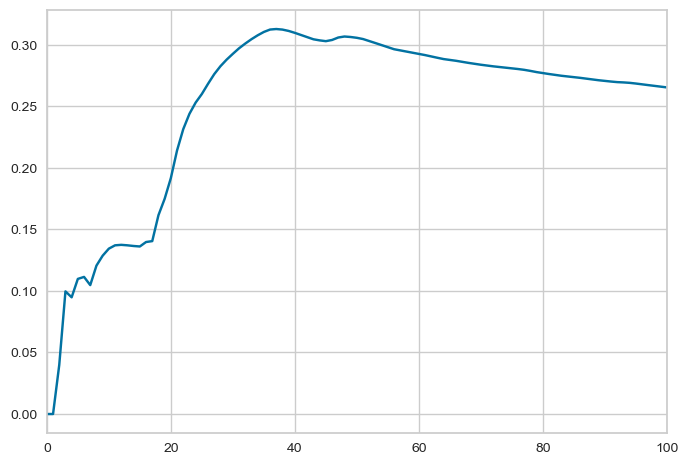

mape


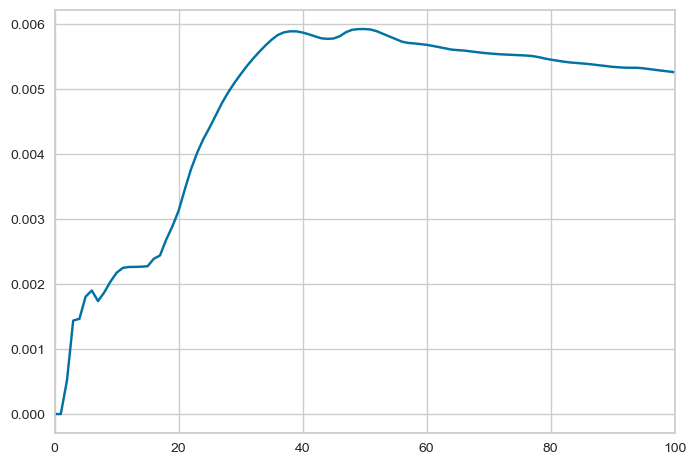

In [83]:
for col in df.columns:
    df[col].plot()
    print(col)
    plt.xlim([0,100])
    plt.show()

mae


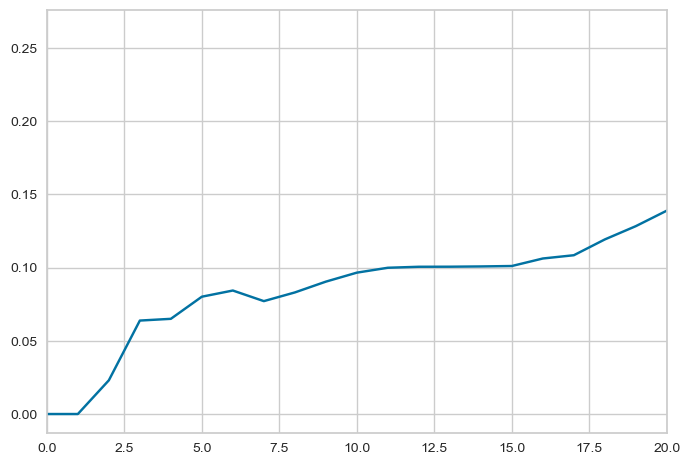

mse


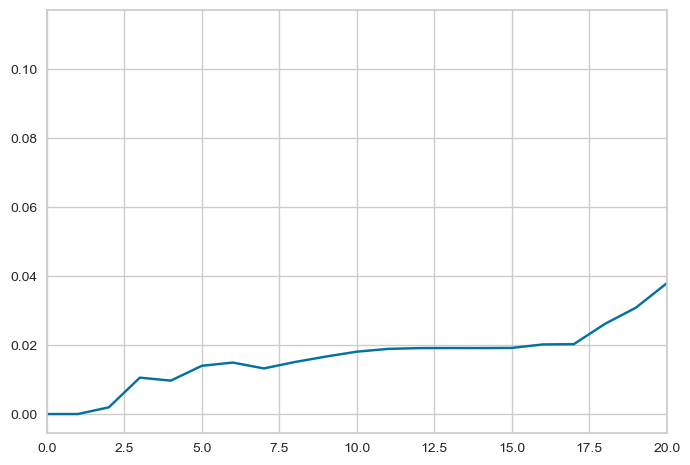

rmse


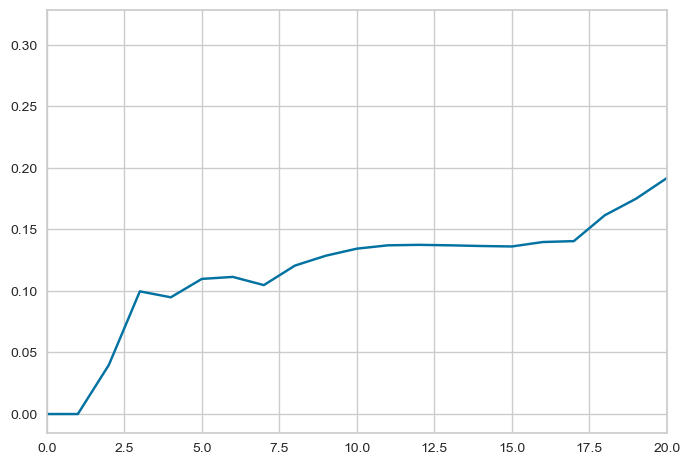

mape


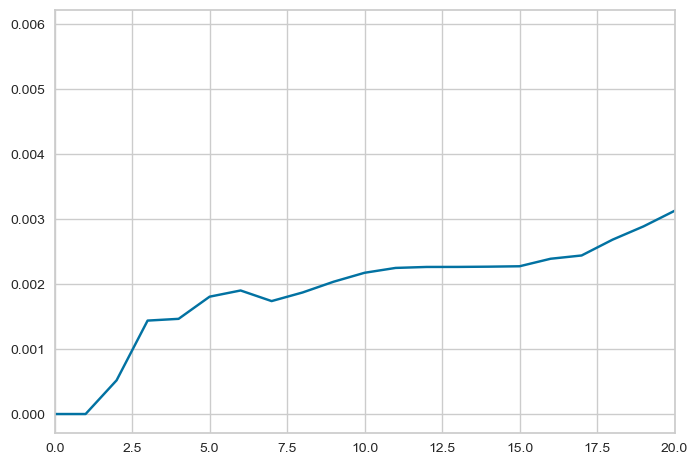

In [84]:
for col in df.columns:
    df[col].plot()
    print(col)
    plt.xlim([0,20])
    plt.show()